<a href="https://colab.research.google.com/github/Sujal-vajire/Machine-learning-models/blob/main/Deep_Learning_Models/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data

* Idea and some code taken from, and also OPSD time series data set explained here: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* Some code and approaches from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [2]:
import pandas as pd
import numpy as np

In [37]:
time_series_df = pd.read_csv('DH2.csv')

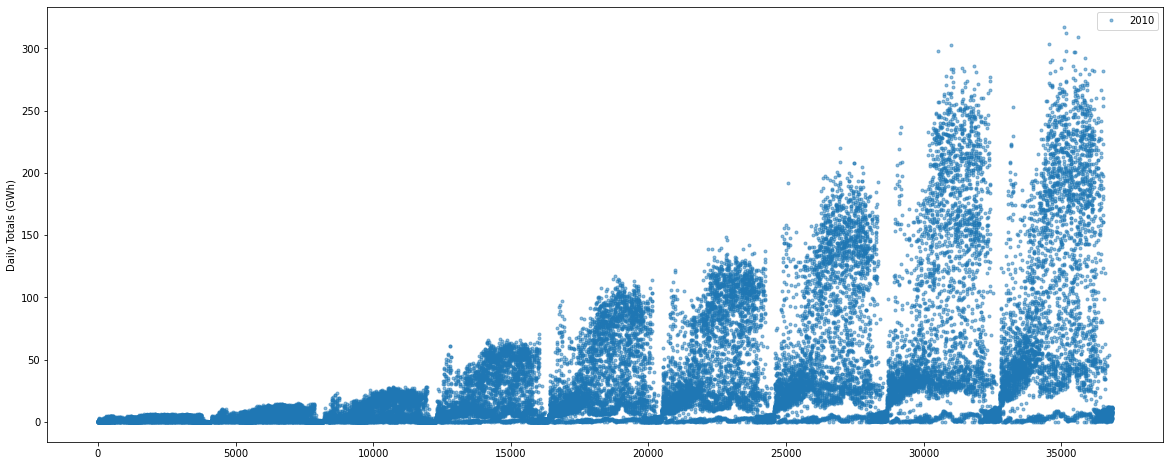

In [38]:
cols_plot = ['2010']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

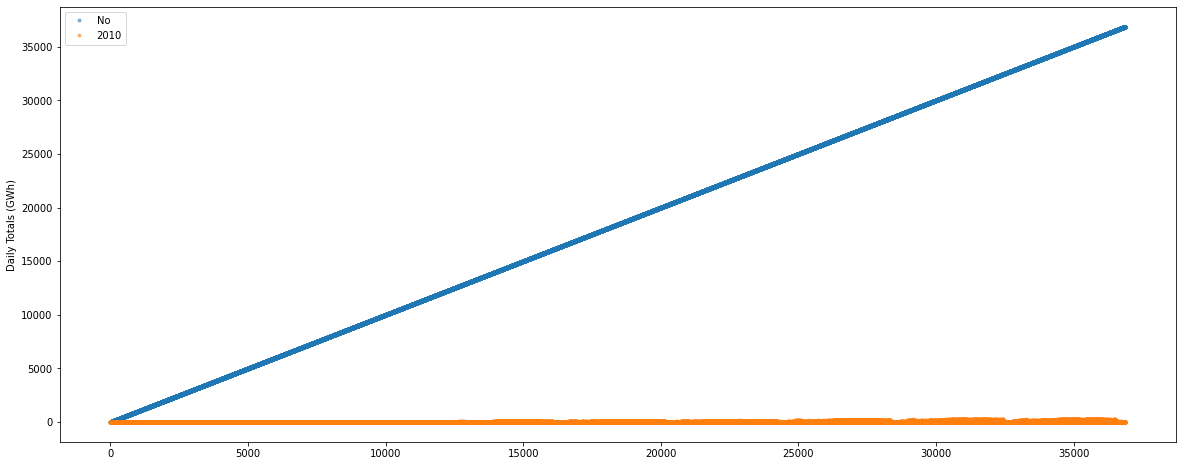

In [39]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (GWh)');

## Can we predict each day's consumption from its past?

### We train on the years 2006 - 2016 and validate on 2017

In [40]:
consumption = time_series_df['2010'].to_numpy()
consumption.shape

(36864,)

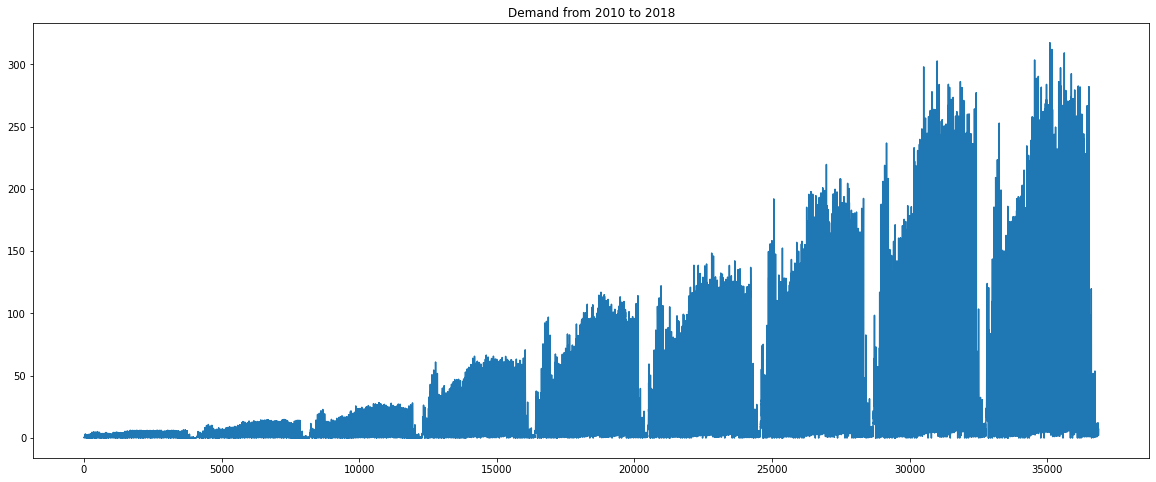

In [41]:
plt.title('Demand from 2010 to 2018')
plt.plot(consumption);

## Statistical Methods directly geared towards forecasting

_Statistical Methods are often favorable: https://twitter.com/togelius/status/1173272424177119233_

* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#targetText=Time%20series%20forecasting%20is%20the,forecasting%20retail%20sales%20time%20series.
* https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* https://research.fb.com/prophet-forecasting-at-scale/

https://www.statsmodels.org
* https://www.statsmodels.org/stable/examples/index.html#stats
* https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
* https://www.statsmodels.org/stable/tsa.html



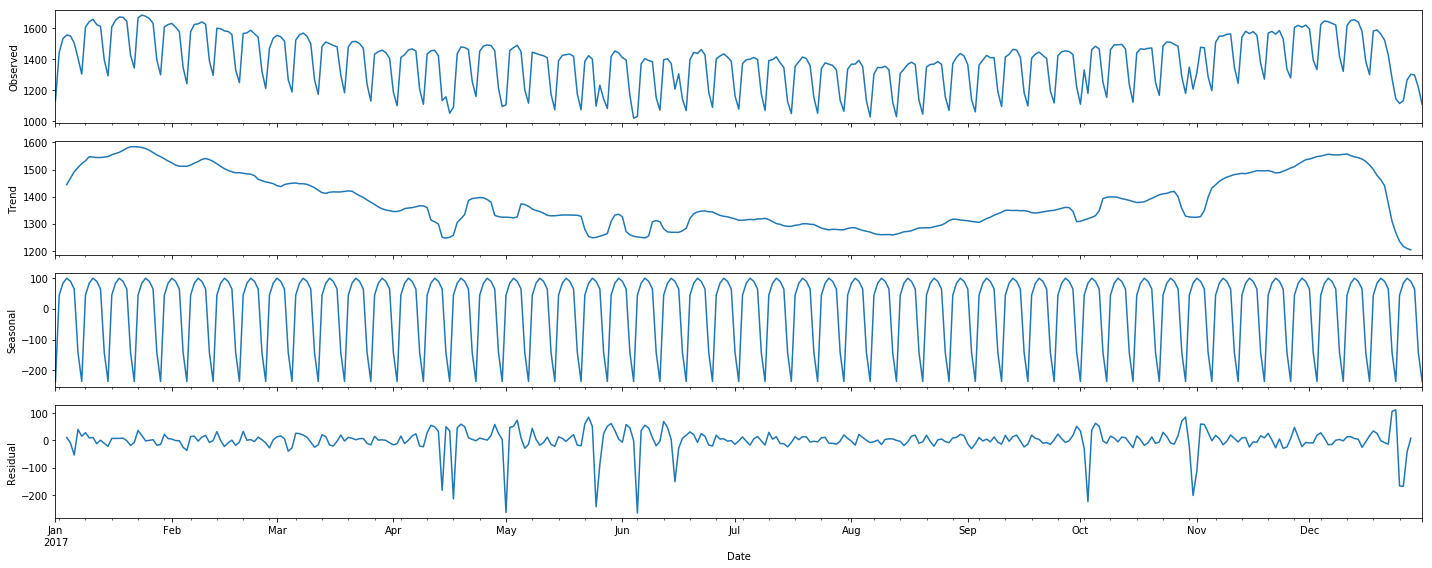

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(time_series_df['2017']['Consumption'], model='additive')
decomposition.plot();

In [42]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### How much of the past would we like for each individual prediction?

In [43]:
#@title Prediction from n past days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [44]:
X, Y = split_sequence(consumption, n_steps_in, n_steps_out)
X.shape, Y.shape

((36834, 30), (36834, 1))

In [45]:
X[0], Y[0]

(array([0.3522418 , 0.32593988, 0.37375234, 0.42068618, 0.47562067,
        0.38015636, 0.44934817, 0.47007074, 0.5373067 , 0.44573437,
        0.45097419, 0.45094751, 0.48824528, 0.39994383, 0.41484813,
        0.48766376, 0.52298331, 0.41898903, 0.37507974, 0.33907722,
        0.3162415 , 0.39508996, 0.39227547, 0.39026173, 0.4176763 ,
        0.3663132 , 0.45490986, 0.45564295, 0.45499106, 0.50545638]),
 array([0.58945972]))

In [46]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(36834, 30, 1)

In [55]:
# we do a special test / train split, 
# we see how well we can predict 2017 as test/validation 


X_train = X[:-1]
Y_train = Y[:-1]

X_test = X[-4095:]
Y_test = Y[-4095:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((36833, 30, 1), (36833, 1), (4095, 30, 1), (4095, 1))

## Baslines

### R2 Metric: MSE and MAE are not speaking

* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


### Rolling mean baseline

In [56]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)

In [57]:
Y_pred_baseline_rolling = rolling_mean_baseline(X)
Y_pred_baseline_rolling.shape

(36834, 1)

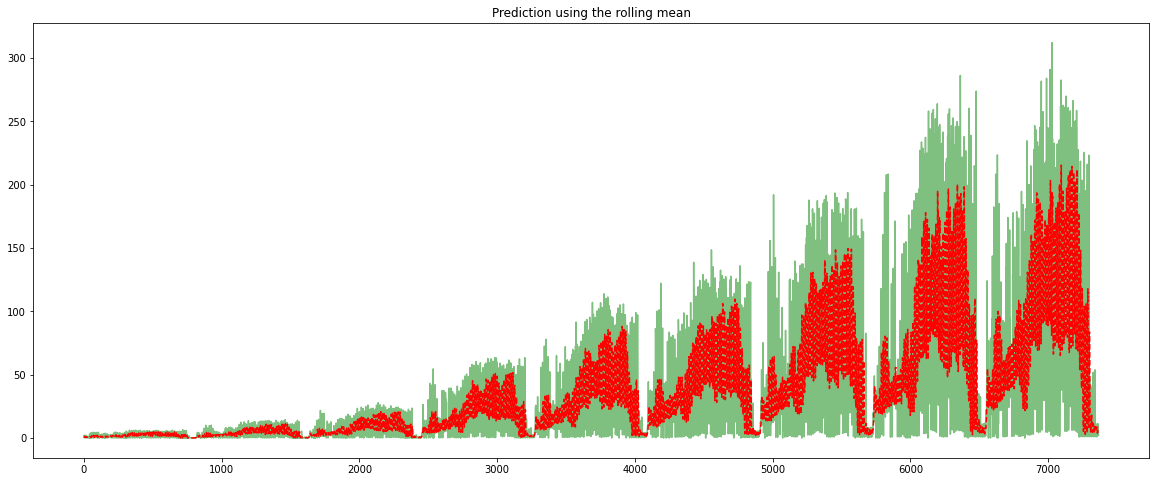

In [58]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_rolling[::stride], color='r', ls='dashed')

plt.title('Prediction using the rolling mean');


In [59]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_rolling)

0.41212715569957614

### Baseline: Previous Value

In [60]:
def previous_value_baseline(history):
  return history[:, -1]

In [61]:
Y_pred_baseline_previous_value = previous_value_baseline(X)
Y_pred_baseline_previous_value.shape

(36834, 1)

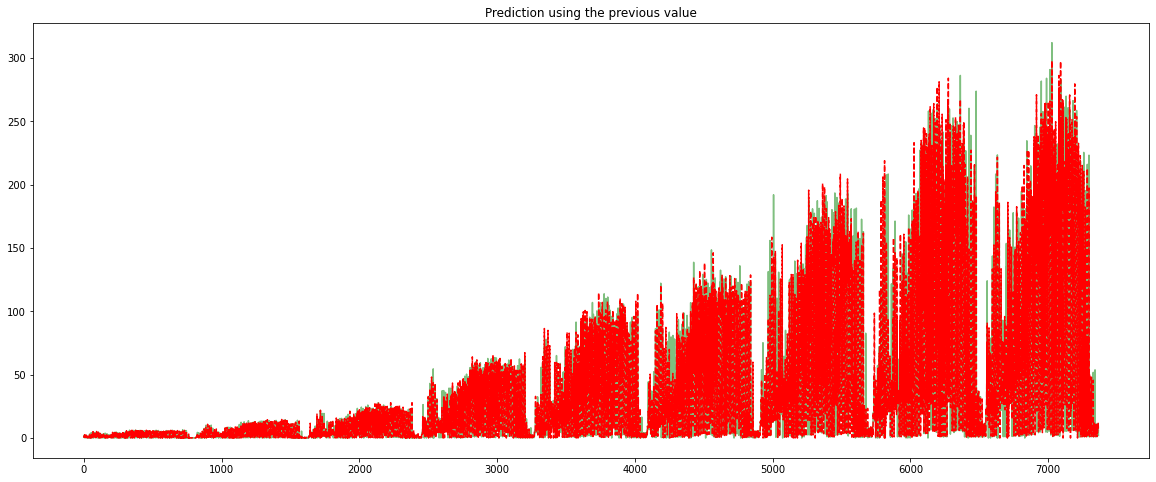

In [62]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[::stride], color='r', ls='dashed')
plt.title('Prediction using the previous value');

### This looks good at first sight, but wait for the R2 score

It is (obviously) always off by one

In [63]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_previous_value)

0.8278336280403883

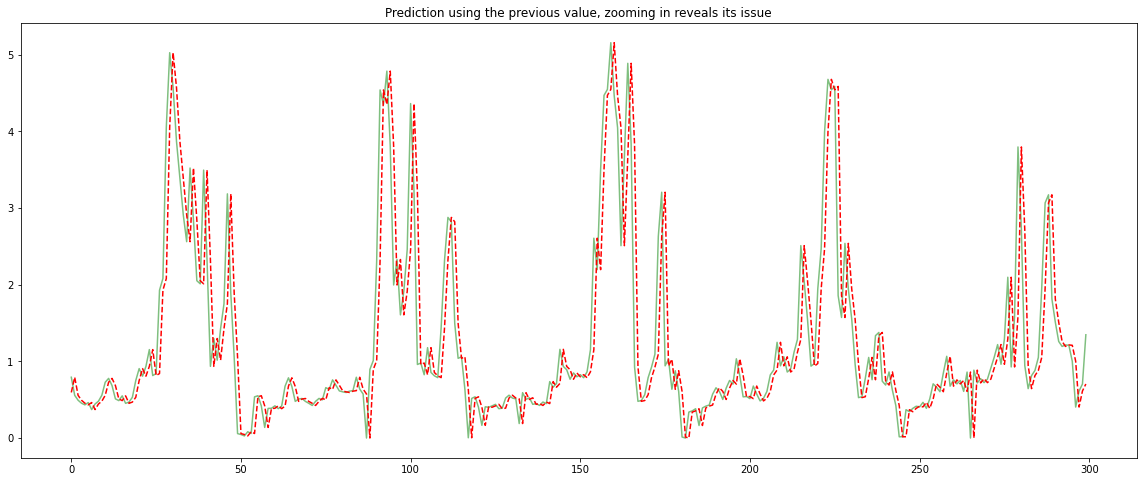

In [64]:
# this gets really crowded, using a stride, makes it more readable
stride = 1
# too crwoded, zoom in
window_start = 300
window_end = 600

plt.plot(consumption[n_steps_in+window_start:n_steps_in+window_end:stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[window_start:window_end:stride], color='r', ls='dashed')

plt.title('Prediction using the previous value, zooming in reveals its issue');

## Prediction using RNNs and TensorFlow

### Can we beat an r2 score around .20?

In [67]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [68]:
import tensorflow as tf
print(tf.__version__)

2.8.2


### Just for the reference, what GPU are we running on?

In [69]:
# What kind of GPU are we running on
!nvidia-smi

Thu Sep  8 11:15:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [70]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

# only works on tensors while training, use sklearn version when using on numpy arrays

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

### Training our model

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

# two layer model, known to work well
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))

# trains faster, but also works
# model.add(GRU(256, activation='relu', input_shape=(n_steps_in, n_features)))

# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))

# horrible results
# model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(64, activation='relu'))

# optional regularization
# model.add(BatchNormalization())
# model.add(Dropout(0.2))


# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [72]:
%%time

batch_size = 32
epochs=25

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/25
1152/1152 [==============================] - 32s 25ms/step - loss: 493.1397 - r2_metric: -inf - val_loss: 1408.7562 - val_r2_metric: 0.5457
Epoch 2/25
1152/1152 [==============================] - 30s 26ms/step - loss: 477.9485 - r2_metric: -inf - val_loss: 1290.2406 - val_r2_metric: 0.5470
Epoch 3/25
1152/1152 [==============================] - 28s 24ms/step - loss: 464.6406 - r2_metric: -inf - val_loss: 1298.7762 - val_r2_metric: 0.5569
Epoch 4/25
1152/1152 [==============================] - 28s 25ms/step - loss: 464.7861 - r2_metric: -inf - val_loss: 1309.8613 - val_r2_metric: 0.5264
Epoch 5/25
1152/1152 [==============================] - 28s 24ms/step - loss: 456.7871 - r2_metric: -inf - val_loss: 1365.3451 - val_r2_metric: 0.5508
Epoch 6/25
1152/1152 [==============================] - 28s 24ms/step - loss: 457.0936 - r2_metric: -inf - val_loss: 1275.2744 - val_r2_metric: 0.5588
Epoch 7/25
1152/1152 [==============================] - 27s 24ms/step - loss: 446.3713 - r2_me

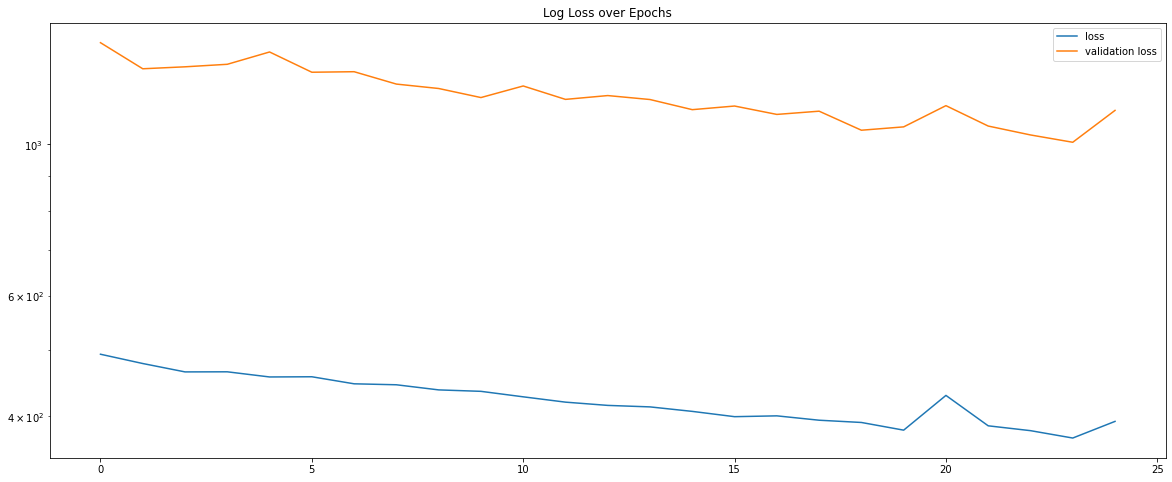

In [73]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

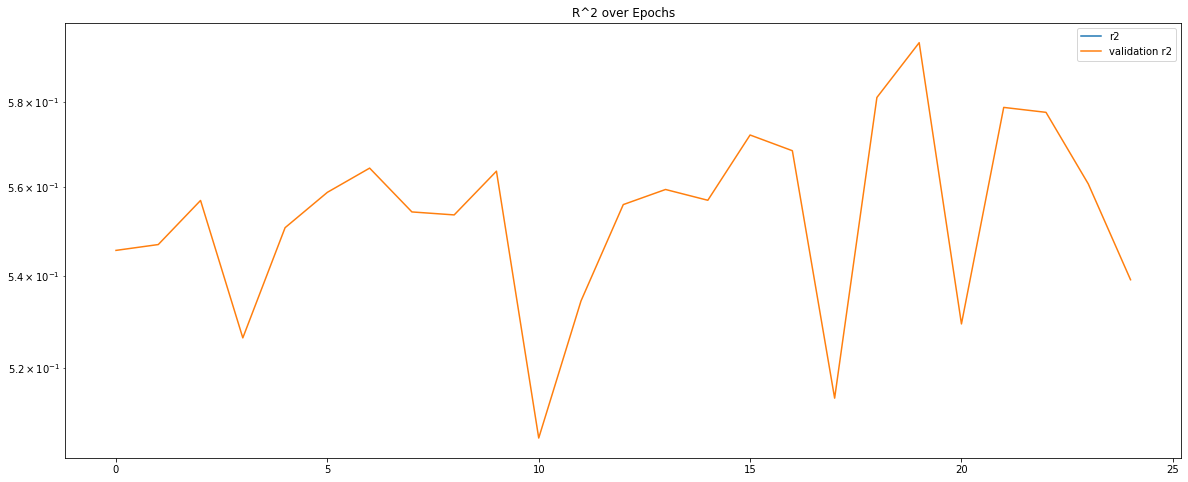

In [74]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [75]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[376.96490478515625, -0.21872290968894958]

### R2 for all data

In [76]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)

0.8717213020400452

### R2 for training data

In [77]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

0.8717202599558692

### R2 for validation data

In [78]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

0.8225900506900321

## Let's plot predicted and true over each other

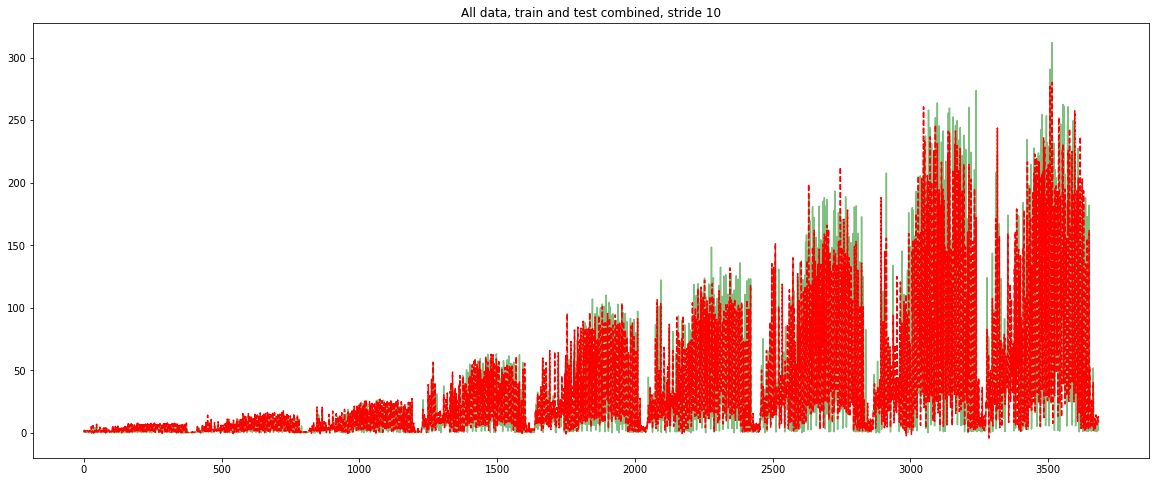

In [79]:
# this gets really crowded, using a stride, makes it more readable
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


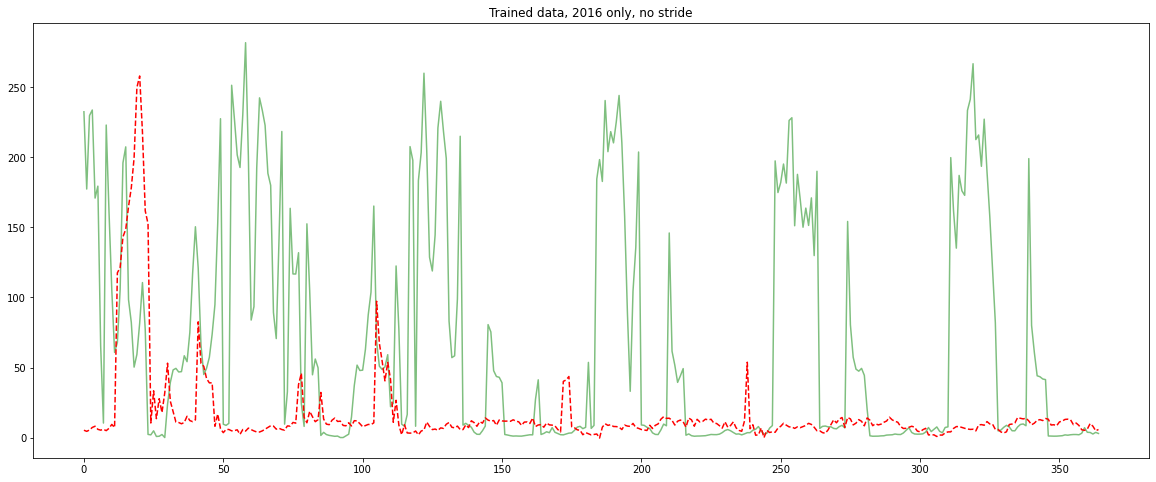

In [80]:
stride = 1


plt.plot(consumption[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2016 only, no stride');


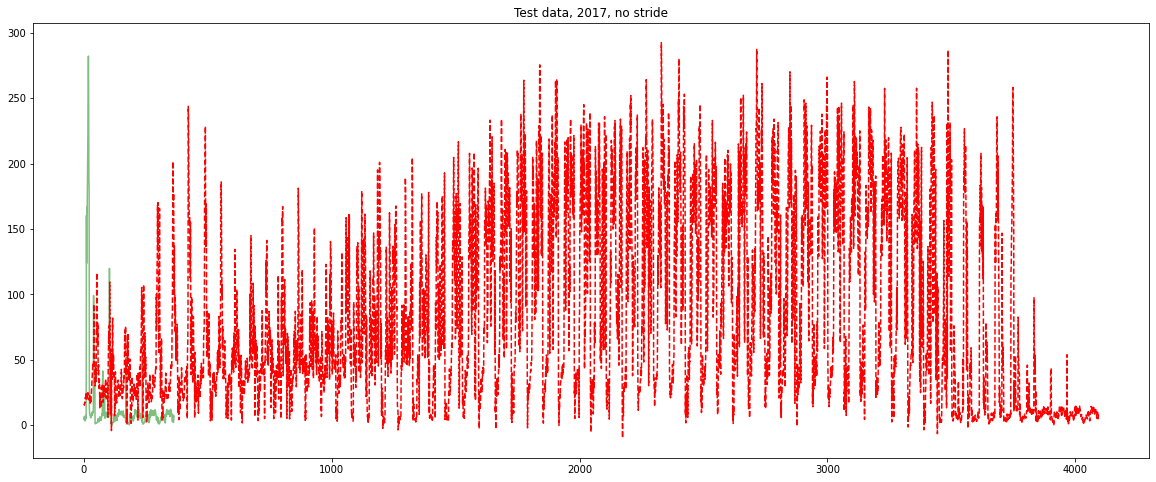

In [81]:
stride = 1


plt.plot(consumption[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2017, no stride');


## Observation / Wrap-Up

### overall a pretty good result
* r2 score is pretty promising
* defintely improved over baseline
* no domain knowledge necessary

### no dramatic difference between training and test data
* neither in metrices
* nor in visual inspection

### peaks and valleys are underestimated very often
* but often the most interesting part
* this seems to be a common problem in time series prediction
* it gets better we train the model for longer
* also when we increase its capacity
* on the other hand this might counter regularization


## Next Steps
  
### make use of seasonal decomposition
* predict each of the components
  * trend should be pretty easy
  * residual shows clear spices on national holidays
  * remove them
  * the results might be noise only
  * but maybe it is not, train a model on it to check
  
### have a more powerful statistical baseline
* Use more powerful statistical models
  * https://www.statsmodels.org/stable/tsa.html
  * http://www.statsmodels.org/dev/tsa.html
  * http://www.statsmodels.org/dev/vector_ar.html
* MSBVAR (Markov-Switching, Bayesian, Vector Autoregression Models) might beat our model, but
  * needs a lot of modelling 
  * does not seem readily available in the Python world (in R it would be)
  
